# AudeyART

In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch import Tensor

## Load Data

In [2]:
datafile = Path("iris", "iris.data")
data = pd.read_csv(datafile, names=["SL", "SW", "PL", "PW", "Label"])

scaler = MinMaxScaler()
data[["SL", "SW", "PL", "PW"]] = scaler.fit_transform(data[["SL", "SW", "PL", "PW"]])
# data

data_cc = torch.Tensor(data[["SL", "SW", "PL", "PW"]].values)
data_cc = torch.cat((data_cc, 1 - data_cc), dim=1)
data_cc

tensor([[0.2222, 0.6250, 0.0678,  ..., 0.3750, 0.9322, 0.9583],
        [0.1667, 0.4167, 0.0678,  ..., 0.5833, 0.9322, 0.9583],
        [0.1111, 0.5000, 0.0508,  ..., 0.5000, 0.9492, 0.9583],
        ...,
        [0.6111, 0.4167, 0.7119,  ..., 0.5833, 0.2881, 0.2083],
        [0.5278, 0.5833, 0.7458,  ..., 0.4167, 0.2542, 0.0833],
        [0.4444, 0.4167, 0.6949,  ..., 0.5833, 0.3051, 0.2917]])

## Define AudeyART (FuzzyART) Module

In [3]:
class AudeyART():

    def __init__(self, dim:int, rho:float=0.6, beta:float=0.5):
        self.W = Tensor(size=[0, 2*dim])
        self.alpha = 0.001
        self.dim = dim
        self.beta = beta
        self.rho = rho
        return

    def grow(self, x: Tensor):
        # print(self.W.shape, x.shape, x.reshape((1, self.dim*2)).shape)

        self.W = torch.cat((self.W, x.reshape((1, self.dim*2))))
        # print(self.W.shape)

    def init_cat(self, x:Tensor):
        n_categories = self.W.shape[0]
        new_W = torch.ones(2*self.dim)
        self.grow(new_W)
        self.learn(x, n_categories)
        return

    def train(self, x:Tensor):
        n_categories = self.W.shape[0]
        if n_categories == 0:
            self.init_cat(x)
            return

        # For loop way
        # T = torch.zeros(n_categories)
        # for j in range(n_categories):
        #     T[j] = self.activation(x, j)

        # List comprehension way
        T = Tensor([self.activation(x, j) for j in range(n_categories)])

        T, inds = torch.sort(T, descending=True)
        did_match = False
        # while not did_match:
        for _, j in enumerate(T):
            # J = int(torch.argmax(T).data)
            J = int(inds[int(j)])
            M = self.match(x, J)
            if M > self.rho:
                self.learn(x, J)
                did_match = True
                break

        if not did_match:
            self.init_cat(x)

        return

    def classify(self, x:Tensor, get_bmu = True):
        n_categories = self.W.shape[0]

        # List comprehension way
        T = Tensor([self.activation(x, j) for j in range(n_categories)])

        y_hat = -1

        T, inds = torch.sort(T, descending=True)
        did_match = False
        # while not did_match:
        for _, j in enumerate(T):
            # J = int(torch.argmax(T).data)
            J = int(inds[int(j)])
            M = self.match(x, J)
            if M > self.rho:
                y_hat = J
                did_match = True
                break

        if not did_match:
            if not get_bmu:
                y_hat = -1
            else:
                y_hat = int(inds[0])

        return y_hat


    def activation(self, x:Tensor, j:int):
        # return torch.sum()
        xinw = torch.minimum(x, self.W[j, :])
        xinwnorm = torch.sum(xinw)
        wnorm = torch.sum(self.W[j, :])
        Tj = xinwnorm / (self.alpha + wnorm)
        return Tj

    def match(self, x:Tensor, j:int):
        xinw = torch.minimum(x, self.W[j, :])
        xinwnorm = torch.sum(xinw)
        Mj = xinwnorm / self.dim
        return Mj

    def learn(self, x:Tensor, j:int):
        # self.W[j, :] = self.beta * x + (1-self.beta) * self.W[j, :]
        self.W[j, :] = (1 - self.beta) * self.W[j, :] + self.beta * (torch.minimum(x, self.W[j, :]))
        return

In [4]:
a = torch.randn(3)
b = torch.argmax(a)
int(b.data)


2

## Init Everything

In [5]:
# Infer data dimensions
n_samples = data_cc.shape[0]
dim = int(data_cc.shape[1] / 2)

# Init FuzzyART module
# aart = AudeyART(dim)

## Train

In [6]:
# Loop over every sample
aart = AudeyART(dim, rho=0.6, beta=1.0)
for ix in range(n_samples):
    data_x = data_cc[ix, :]
    aart.train(data_x)
    # print(data_x)

y_hats = []
for ix in range(n_samples):
    data_x = data_cc[ix, :]
    y_hat = aart.classify(data_x)
    y_hats.append(y_hat)

In [7]:

from matplotlib import pyplot as plt
from matplotlib import ticker

from sklearn.manifold import TSNE
# from sklearn.metrics import ConfusionMatrixDisplay
%matplotlib inline


def add_2d_scatter(ax, points, colors, title=None):
    x, y = points.T
    ax.scatter(x, y, s=50, c=colors, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())

def plot_2d(points, colors, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, colors)
    plt.show()


t_sne = TSNE(
    n_components=2,
    perplexity=10,
    init="random",
    max_iter=250,
    random_state=0,
)

x = data[["SL", "SW", "PL", "PW"]].values
y = y_hats

S_t_sne = t_sne.fit_transform(x)


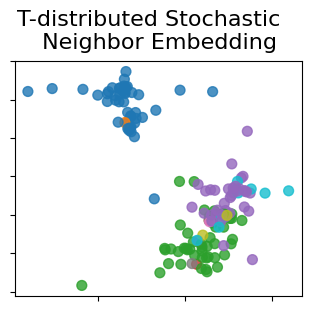

In [8]:
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in y]
plot_2d(S_t_sne, colors, "T-distributed Stochastic  \n Neighbor Embedding")

In [9]:
a = torch.Tensor(size=[0,2])
b = torch.Tensor(np.array([[1, 1]]))
# a.expand( )
print(a.shape)
print(b.shape)
c = torch.cat((a, b))
c.shape

torch.Size([0, 2])
torch.Size([1, 2])


torch.Size([1, 2])